In [1]:
# Import packages

# Data Cleaning
import pandas as pd
import numpy as np

# Numerical encoding of all categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans #For KMeans
from sklearn.cluster import AgglomerativeClustering #hierarchy
import scipy.cluster.hierarchy as sch #hierarchy
from sklearn.cluster import DBSCAN #DBSCAN
%matplotlib inline

# Dimensionality Reduction
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
from MultiColumnLabelEncoder import MultiColumnLabelEncoder # custom function

In [3]:
# Load dataset
df = pd.read_csv('../preparation/cleaned_df.csv')

In [4]:
df.head()

,imdbID,Title,Year,Month,Box_Office,IMDB_Value,RT_Value,MC_Value,Vote_Average,Rated,Director,Language,Country,Runtime,Actor_1,Actor_2,Actor_3,Genre_1,Genre_2,Genre_3
0,tt0114709,Toy Story,1995,10,223225679.0,83.0,100.0,95.0,79.65,G,John Lasseter,English,United States,81,Tom Hanks,Tim Allen,Don Rickles,Animation,Adventure,Family
1,tt0113497,Jumanji,1995,12,100499940.0,70.0,52.0,39.0,72.00,PG,Joe Johnston,English,United States,104,Robin Williams,Kirsten Dunst,Bonnie Hunt,Adventure,Fantasy,Family
2,tt0113228,Grumpier Old Men,1995,12,71518503.0,66.0,17.0,46.0,64.41,PG-13,Howard Deutch,English,United States,101,Walter Matthau,Jack Lemmon,Ann-Margret,Romance,Comedy,NaN
3,tt0114885,Waiting to Exhale,1995,12,67052156.0,59.0,61.0,63.0,63.00,R,Forest Whitaker,English,United States,127,Whitney Houston,Angela Bassett,Loretta Devine,Comedy,Drama,Romance
4,tt0113041,Father of the Bride Part II,1995,12,76594107.0,60.0,52.0,49.0,62.28,PG,Charles Shyer,English,United States,106,Steve Martin,Diane Keaton,Martin Short,Comedy,Family,NaN


In [5]:
df_modeling = df.copy(deep=True)

In [6]:
df_modeling.drop(columns=['imdbID','Title'], inplace=True)

first pass : no good scaling, no feature engineering, just encoding

In [7]:
num_feat = list(df_modeling.select_dtypes(include=['float','int']))
cat_feat = list(df_modeling.select_dtypes(include=['object']))

In [8]:
num_feat

['Year',
 'Month',
 'Box_Office',
 'IMDB_Value',
 'RT_Value',
 'MC_Value',
 'Vote_Average',
 'Runtime']

In [9]:
cat_feat

['Rated',
 'Director',
 'Language',
 'Country',
 'Actor_1',
 'Actor_2',
 'Actor_3',
 'Genre_1',
 'Genre_2',
 'Genre_3']

In [14]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [17]:
df_modeling = MultiColumnLabelEncoder(columns = ['Rated', 'Director', 'Language',
                                   'Country', 'Actor_1', 'Actor_2',
                                   'Actor_3', 'Genre_1', 'Genre_2', 
                                   'Genre_3']).fit_transform(df_modeling)

In [19]:
df_modeling.describe()

,Year,Month,Box_Office,IMDB_Value,RT_Value,MC_Value,Vote_Average,Rated,Director,Language,Country,Runtime,Actor_1,Actor_2,Actor_3,Genre_1,Genre_2,Genre_3
count,9626.000000,9626.000000,9.626000e+03,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000
mean,1994.574694,6.874922,3.515210e+07,66.201447,62.650791,60.199099,65.233715,9.742780,2166.250467,21.526283,56.918762,104.325473,2026.056098,2622.956368,3107.921359,5.196343,9.518699,14.340121
std,18.596111,3.425791,8.375583e+07,10.108779,26.499415,16.564459,8.660635,3.720594,1221.334286,8.228186,17.911031,24.458226,1162.342887,1502.120943,1802.048911,4.193389,6.287164,6.038495
min,1902.000000,1.000000,0.000000e+00,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1987.000000,4.000000,2.233610e+05,60.000000,43.875000,50.000000,60.000000,8.000000,1128.000000,19.000000,65.000000,92.000000,1031.000000,1311.250000,1524.000000,3.000000,4.000000,10.000000
50%,1999.000000,7.000000,8.311460e+06,67.000000,68.000000,62.000000,65.770000,9.000000,2181.500000,19.000000,66.000000,102.000000,1952.000000,2609.000000,3059.500000,4.000000,8.000000,19.000000
75%,2008.000000,10.000000,3.714605e+07,73.000000,85.000000,72.000000,71.345000,11.000000,3251.000000,19.000000,66.000000,115.000000,3056.000000,3916.750000,4660.750000,6.000000,16.000000,19.000000
max,2018.000000,12.000000,2.920357e+09,93.000000,100.000000,100.000000,89.460000,21.000000,4208.000000,71.000000,70.000000,583.000000,4041.000000,5220.000000,6198.000000,19.000000,19.000000,19.000000


In [20]:
# Scale all feautures for PCA computation
s_scaler = StandardScaler()
n_scaler = MinMaxScaler()
r_scaler = RobustScaler()

In [23]:
df_scaled = pd.DataFrame(n_scaler.fit_transform(df_modeling), columns=df_modeling.columns)

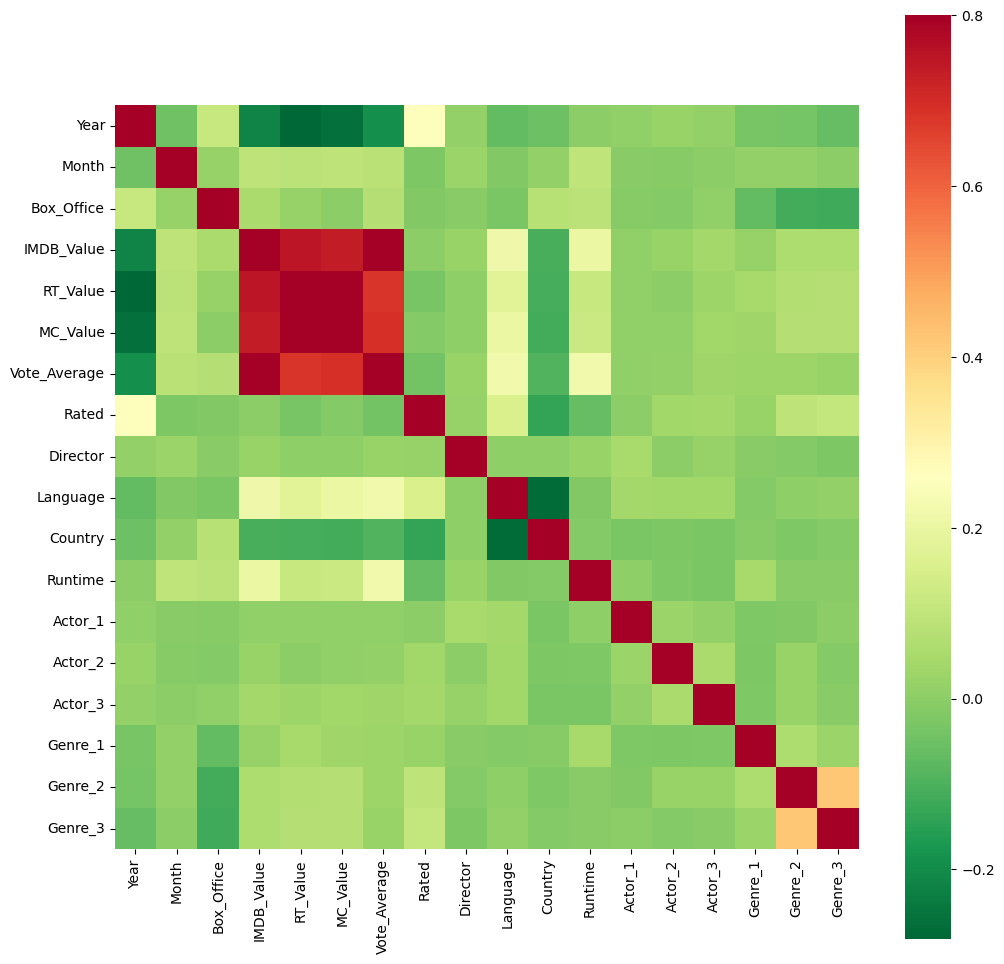

In [25]:
cormat = df_scaled.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cormat, vmax=.8, square=True, cmap="RdYlGn_r");

### Scree Plot

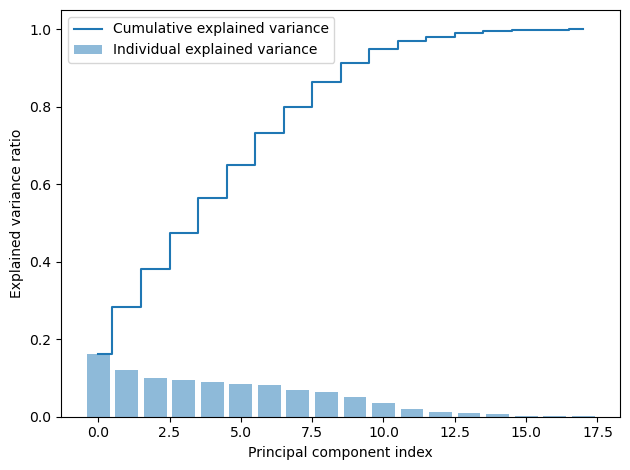

In [26]:
#scree plot
pca = PCA()

# Determine transformed features

data_pca = pca.fit_transform(df_scaled)

# Determine explained variance using explained_variance_ration_ attribute

exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [27]:
def apply_pca(df, components):
    columns = []
    for i in range(components):
        columns.append(f'column {i + 1}')
    pca = PCA(n_components=components)
    result = pca.fit_transform(df)
    pca_df = pd.DataFrame(data = result, columns=columns)
    return pca_df

In [28]:
df_pca = apply_pca(df_scaled, 10)

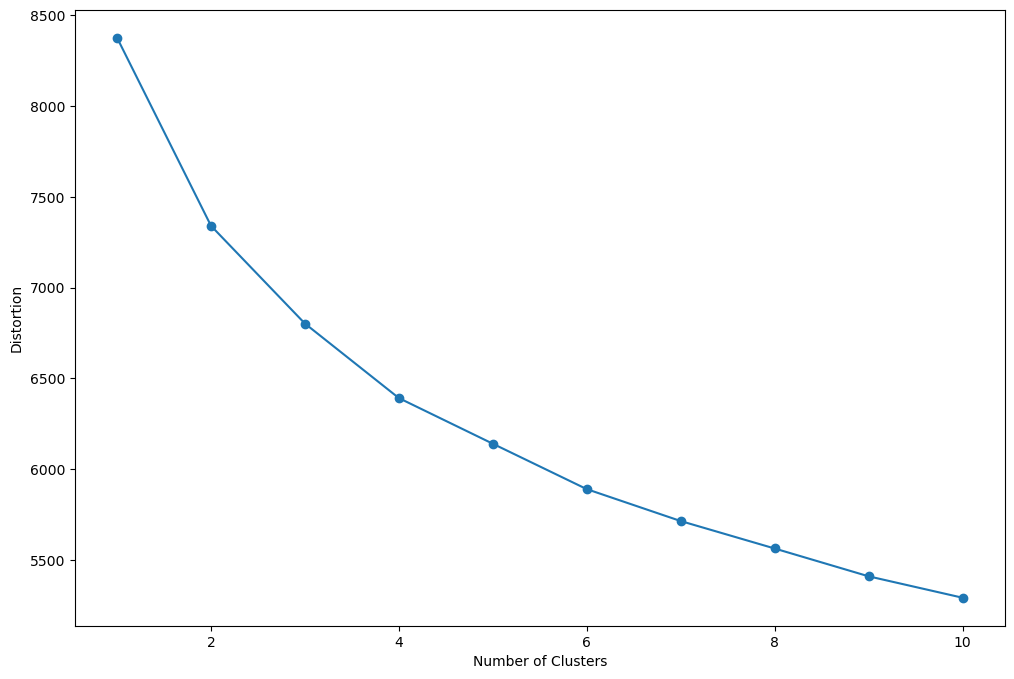

In [29]:
# calculating distortion for kmeans
distortions = []
for i in range (1,11):
    km = KMeans(n_clusters = i,
               n_init=10)
    km.fit(df_pca)
    distortions.append(km.inertia_)
plt.rcParams["figure.figsize"] = (12,8)    
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [30]:
# 4 clusters?
X = df_pca

# K-Means
km = KMeans(n_clusters=4, init='k-means++')
y_km = km.fit_predict(X)

# Hierarchical
ac = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=3)
y_ac = ac.fit_predict(X)

# DBSCAN
dpebs = 0.8
dbsample = 3
db = DBSCAN(eps=dpebs, min_samples=dbsample, metric='euclidean')
y_db = db.fit_predict(X)

C:\Users\annie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\annie\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [31]:
# plotting function

def plot_clusters(X,y_res, plt_cluster_centers = True):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

### K-Means

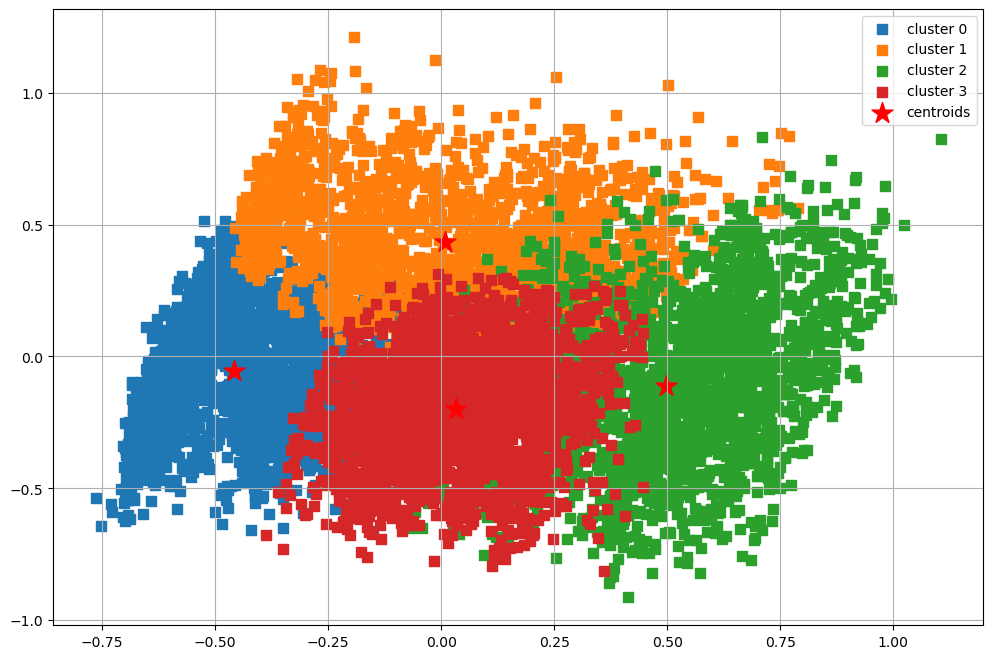

In [32]:
plot_clusters(np.array(df_pca), y_km)

In [33]:
# Calculate silhoutte score of k-means clustering
score = metrics.silhouette_score(X, km.labels_, metric='euclidean')

# Print score to 3 decimal places
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.094


### Hierarchical

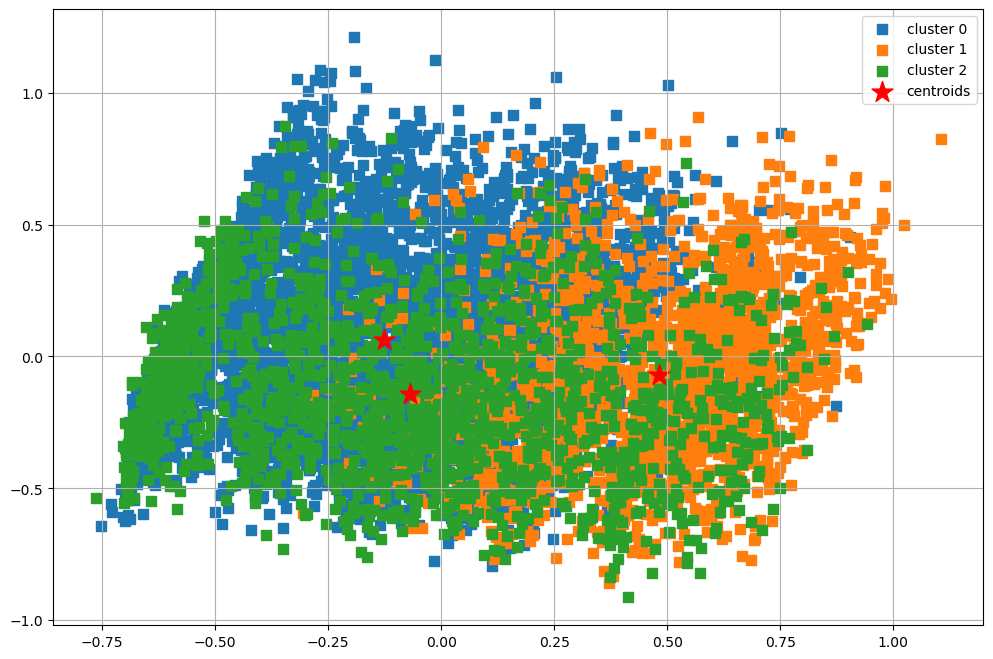

In [34]:
plot_clusters(np.array(X), y_ac)

In [35]:
# Calculate silhoutte score of hierarchical clustering
score = metrics.silhouette_score(X, ac.labels_, metric='euclidean')

# Print score to 3 decimal places
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.103


### DBSCAN

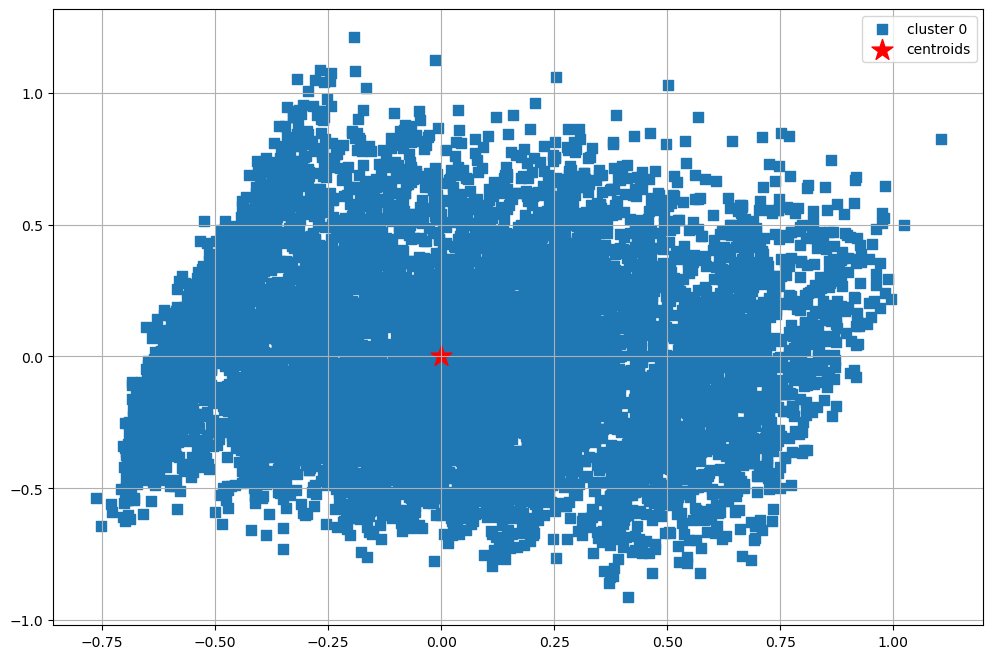

In [36]:
plot_clusters(np.array(X), y_db)

In [37]:
# Calculate silhoutte score of DBSCAN clustering
score = metrics.silhouette_score(X, db.labels_, metric='euclidean')

# Print score to 3 decimal places
print('Silhouette Score: %.3f' % score)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

clearly need to do way more adjusting here